# Using Snorkel to Extract Education of Actresses and Actors

<sub>Content of this notebook was prepared by Basel Shbita (shbita@usc.edu) as part of the class <u>DSCI 558: Building Knowledge Graphs</u> during Fall 2020 at University of Southern California (USC).</sub>

**Notes**: 
- You are supposed to write your code or modify our code in any cell starting with `# ** STUDENT CODE`.
- Much content of this notebook was borrowed from Snorkel Introduction Tutorial

State-of-the-art extraction techniques require massive labeled training set but it is costly to obtain. To overcome this problem, Snorkel helps rapidly create training sets using the new data programming paradigm. To start, developers focus on writing a set of labeling functions, which are just scripts that programmatically label data. The resulting labels are noisy, but Snorkel uses a generative model to learn how to use those labeling functions to label more data. The new labeled data now can be used to train high-quality end models.

**In summary, in this task, you will first manually label 99 documents and use these labeled data as a development set to create your own labeling functions. Then, you will train a generative model to label 1025 documents in training set. Finally, you will train a discriminative model (Bi-LSTM) to produce your final extraction model!**

## Creating a development set

Before you proceed with task 1, we need to preprocess our documents using `Snorkel` utilities, parsing them into a simple hierarchy of component parts of our input data, which we refer as _contexts_. We'll also create _candidates_ out of these contexts, which are the objects we want to classify, in this case, possible mentions of schools and colleges that the cast have attended. Finally, we'll load some gold labels for evaluation.

All of this preprocessed input data is saved to a database. In Snorkel, if no database is specified, then a SQLite database at `./snorkel.db` is created by default -- so no setup is needed here!

In [1]:
# ** STUDENT CODE

import numpy as np, os
from pathlib import Path

from snorkel.annotations import  load_gold_labels

from utils import reload_external_labels, save_predicted_relations, get_gold_labels

# TODO: Set location where you store your homework 5 files
if 'HW_DIR' not in os.environ:
    HW_DIR = Path("./data")
else:
    HW_DIR = Path(os.environ['HW_DIR'])
    assert HW_DIR.exists()

**Initializing a `SnorkelSession`**

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from snorkel import SnorkelSession
session = SnorkelSession()

**Loading the Corpus**

Next, we load and pre-process the corpus of documents.

In [3]:
from snorkel.parser import TSVDocPreprocessor, CorpusParser

doc_preprocessor = TSVDocPreprocessor(HW_DIR / 'cast_bios.tsv')

**Running a `CorpusParser`**

We'll use [Spacy](https://spacy.io/), an NLP preprocessing tool, to split our documents into sentences and tokens, and provide named entity annotations.

In [4]:
from snorkel.parser.spacy_parser import Spacy

corpus_parser = CorpusParser(parser=Spacy())
%time corpus_parser.apply(doc_preprocessor) # TSVDocPreprocessor

Clearing existing...
Running UDF...
CPU times: user 11.7 s, sys: 212 ms, total: 11.9 s
Wall time: 12 s


We can then use simple database queries (written in the syntax of [SQLAlchemy](http://www.sqlalchemy.org/), which Snorkel uses) to check how many documents and sentences were parsed:

In [5]:
from snorkel.models import Document, Sentence

print("Documents:", session.query(Document).count()) #1423
print("Sentences:", session.query(Sentence).count()) # 6933

Documents: 1423
Sentences: 6933


**Generating Candidates**

The next step is to extract _candidates_ from our corpus. A `Candidate` in Snorkel is an object for which we want to make a prediction. In this case, the candidates are pairs of person and organization mentioned in sentences.

The [Spacy](https://spacy.io/) parser we used performs _named entity recognition_ for us. Next, we'll split up the documents into train, development, and test splits; and collect the associated sentences.

In [6]:
from snorkel.models import candidate_subclass

# helper function: kinda like namedtuple
Education = candidate_subclass('Education', ['person', 'organization'])

In [7]:
from snorkel.candidates import Ngrams, CandidateExtractor
from snorkel.matchers import PersonMatcher, OrganizationMatcher

ngrams         = Ngrams(n_max=7) # 7 words long
person_matcher = PersonMatcher(longest_match_only=True) # Matches Spans that are the names of people
org_matcher    = OrganizationMatcher(longest_match_only=True) # Matches Spans that are the names of organizations
cand_extractor = CandidateExtractor(Education, [ngrams, ngrams], [person_matcher, org_matcher])

In [8]:
from utils import get_dev_doc_ids, get_test_doc_ids, number_of_people

docs = session.query(Document).order_by(Document.name).all()

dev_docs = get_dev_doc_ids(HW_DIR / "cast.dev.txt") # {'https://www.imdb.com/name/nm0000096', 'nm0000402',...}
test_docs = get_test_doc_ids(HW_DIR / "cast.test.txt") # {'https://www.imdb.com/name/nm0000102', 'nm0000171',...}

train_sents = set()
dev_sents   = set()
test_sents  = set()

# predefined dev/test/train set
for doc in docs:
    # if a sentences mention more than five people -> unlikely contain "people education" relation.
    sents = (s for s in doc.sentences if number_of_people(s) <= 5) 
    if doc.name in dev_docs:
        dev_sents.update(sents)
    elif doc.name in test_docs:
        test_sents.update(sents)
    else:
        train_sents.update(sents)
        
print("Number of dev sentences:", len(dev_sents)) # 489
print("Number of train sentences:", len(train_sents)) # 4839
print("Number of test sentences:", len(test_sents)) # 1551

Number of dev sentences: 489
Number of train sentences: 4839
Number of test sentences: 1551


Finally, we'll apply the candidate extractor to the three sets of sentences. The results will be persisted in the database backend.

In [9]:
# %%time
# UDF ~ labeling function 
# iterate through train, dev, test
for i, sents in enumerate([train_sents, dev_sents, test_sents]):
    cand_extractor.apply(sents, split=i)
    print("Number of candidates:", session.query(Education).filter(Education.split == i).count())

  1%|          | 27/4839 [00:00<00:18, 264.27it/s]

Clearing existing...
Running UDF...


  7%|▋         | 32/489 [00:00<00:01, 319.31it/s]

Number of candidates: 3094
Clearing existing...
Running UDF...


  2%|▏         | 29/1551 [00:00<00:05, 256.59it/s]

Number of candidates: 346
Clearing existing...
Running UDF...


100%|██████████| 1551/1551 [00:05<00:00, 303.10it/s]

Number of candidates: 890


### Sum Up


| dataset   | \# sentences |
| ----- | ------------ |
| dev   | 668          |
| train | 6311         |
| test  | 2029         |


| dataset   | \# candidates |
| ----- | ------------ |
| dev (1)  | 346          |
| train (0) | 3094         |
| test (2) | 890         |


## Task 1: Label 99 documents in development set

In this task, you will use `SentenceNgramViewer` to label each mention. You can click the green button to mark the candidate as correct, red button to mark as incorrect. Your labeling result is automatically stored in the database.

In [10]:
# since saved development set

reload_external_labels(session, HW_DIR / "Ziheng_Gong_hw05_gold_labels.dev.json")
# reload_external_labels(session, HW_DIR / "gold_labels.test.json")

# load existing labels for a development set: split 1
gold_labels = load_gold_labels(session, annotator_name='gold', split=1)

AnnotatorLabels created: 346
AnnotatorLabels created: 186


In [10]:
# if need to label

from snorkel.viewer import SentenceNgramViewer

gold_labels = get_gold_labels(session)

labeled_sents = {lbl.candidate.person.sentence.id for lbl in gold_labels}

unlabeled = [
    x for x in session.query(Education).filter(Education.split == 1).all() 
    if x.person.sentence.id not in labeled_sents
]
print("Number unlabeled:", len(unlabeled))

SentenceNgramViewer(unlabeled, session, annotator_name="gold")

Number unlabeled: 346


<IPython.core.display.Javascript object>

SentenceNgramViewer(cids=[[[36, 37, 219, 220, 326, 327], [159, 236, 252, 295], [51, 118, 191]], [[169, 170], […

After you finish labeling, executing the cell below to **save your result** to JSON files. 

In [28]:
from utils import save_gold_labels, save_gold_relations

save_gold_labels(session, HW_DIR / "Ziheng_Gong_hw05_gold_labels.dev.json", split=1)
save_gold_relations(session, HW_DIR / "Ziheng_Gong_hw05_extracted_relation.dev.json", split=1)

## Tasks 2 & 3: Define labeling functions (LFs)

In these tasks, you will define your own LFs, which Snorkel uses to create noise-aware training set. Usually, you will go through a couple of iterations (create LFs, test and refine it) to come up with a good set of LFs. We provide you at the end of this section a helper to quickly see what candidates did your model fail to classify. You can refer to Snorkel tutorial or online documentation for more information.

You are free to use write any extra code to create a set of sophisticated LFs. For example, you can build a list of universities and check if it matches with your candidate.

In [11]:
import re
from snorkel.lf_helpers import (
    get_left_tokens, get_right_tokens, get_between_tokens,
    get_text_between, get_tagged_text, contains_token
)

`c`: `<class 'snorkel.models.candidate.Education'>`
- `c[0]`: `person`  `<class 'snorkel.models.context.Span'>`
- `c[1]`: `organization` `<class 'snorkel.models.context.Span'>`
 
c.person

In [12]:
# ** STUDENT CODE

from snorkel.lf_helpers import test_LF

verbs = {'attended', 'educated','returned', 'studied', 'enrolled', 'graduated'}
def LF_between(c):
    between_tokens = list(get_between_tokens(c))
    if verbs.intersection(between_tokens) :
#         print(c[0].get_span(),"\t",between_tokens,"\t",c[1].get_span())
        return 1
    else:
        return -1

def LF_organization_right_movie_denial(c):
    """
    if an entitiy's right token includes '(' ')' '1992' etc.
    it's a movie entitiy, not a organization entitiy
    """
    right_token = ''.join(list(get_right_tokens(c[1],window = 3)))
    if re.match(r'\(\d{4}\)',right_token):
        return -1
    else:
        return 0

def LF_person_right_movie_denial(c):
    """
    if an entitiy's right token includes '(' ')' '1992' etc.
    it's a movie entitiy, not a organization entitiy
    """
    right_token = ''.join(list(get_right_tokens(c[0],window = 3)))
    if 'family' in right_token:
        return -1
    if re.match(r'\(\d{4}\)',right_token):
        return -1
    else:
        return 0

        
    
schools = {'school','university','college','institute'}    
def LF_ending_word(c):
    span = c.organization.get_span().lower()
    flag = -1
    for school in schools:
        if school in span:
            flag = 1
            break
    return flag
        
    
# trying to increase positve label
def LF_between_ending(c):
    flag = 0
    between_tokens = list(get_between_tokens(c))
    if LF_between(c) == 1 and LF_ending_word(c) == 1:
        for bad_word in ['back','founded']:
            if bad_word in between_tokens:
                flag =  -1
                break
            else:
                flag = 1
    return flag

def LF_person_right_punctuation_denial(c):
    right_token = list(get_right_tokens(c[0],window = 1))
    print(right_token)                       
    return 0


def LF_usc(c):
    if c[1].get_span() == "USC":
        person = c[0].get_span()
        if person == 'John Singleton':
            return 1
        else:
            return -1
    elif c[1].get_span() == 'Film Writing Program':
        return -1
    else:
        return 0
    
    
def LF_HarryPotter(c):
    person = c[0].get_span()
    school = c[1].get_span()
    
    if LF_between_ending(c) == 1 or LF_person_school_distance(c) == 1:
        if person == "Harry Potter":
            print(person)
            return -1
        if school == 'the Brothers Grimm':
            return -1
        return 1
    else:
        return 0
    
# My model may overfitting, trying to make up

def LF_naive_distance(c):
    distance = len(list(get_between_tokens(c)))
    if distance >= 7:
        return 0  
    else:
        return 1
    
def LF_person_school_distance(c):
    if LF_ending_word(c) == 1:
        distance = len(list(get_between_tokens(c)))
        if distance <= 3:
            return 1
        else:
            return 0
    else:
        return 0
    
# tp, fp, tn, fn = test_LF(session, LF_person_school_distance, split=1, annotator_name='gold')

# SentenceNgramViewer(fp, session)

In [13]:
# ** STUDENT CODE

# Task 3 Distant supervision
from SPARQLWrapper import SPARQLWrapper, JSON

def LF_distant_supervision(c):
    is_school = LF_ending_word(c)
    
    person = c[0].get_span()
    school = re.findall(r"\w+", c[1].get_span())
    person_pattern = '|'.join(person.split(' '))
    school_pattern = '|'.join(school)

    sparql = SPARQLWrapper("http://dbpedia.org/sparql") 
    sparql.setQuery(f"""
        PREFIX dcterms: <http://purl.org/dc/terms/>
        PREFIX foaf: <http://xmlns.com/foaf/0.1/>
        PREFIX owl: <http://www.w3.org/2002/07/owl#>
        PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
        PREFIX xml: <http://www.w3.org/XML/1998/namespace/>
        PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
        PREFIX dbo: <http://dbpedia.org/ontology/> 
        prefix dbp: <http://dbpedia.org/property/> 
        
        SELECT ?person_name ?school_name
        WHERE {{
            ?person a dbo:Person ; 
                foaf:name ?person_name ;
                dbo:almaMater [ foaf:name ?school_name ] .
            FILTER(REGEX(?person_name, "{person_pattern}","i"))
            FILTER(REGEX(?school_name, "{school_pattern}","i"))
        }}
        """)
    sparql.setReturnFormat(JSON)
    try:
        results = sparql.query().convert()
        binding = results['results']['bindings']
    except:
        binding = False
    
    if is_school and binding:
        return 1
    else:
        return 0
            
# tp, fp, tn, fn = test_LF(session, LF_distant_supervision, split=1, annotator_name='gold')            

In [14]:
# ** STUDENT CODE
LFs = [
    LF_between, LF_organization_right_movie_denial, LF_person_right_movie_denial, 
    LF_ending_word, LF_between_ending, LF_usc, LF_person_school_distance, LF_HarryPotter
]

---

Applying the label functions:

- run the LFs over all of our training candidates
- producing a set of `Labels` and `LabelKeys` (just the names of the LFs) in the database.
- by using the `LabelAnnotato`r class, a UDF which we will again run with UDFRunner . 
    - Note that this will delete any existing `Labels` and `LabelKeys` for this candidate set.

In [15]:
from snorkel.annotations import LabelAnnotator

np.random.seed(1701)

labeler = LabelAnnotator(lfs=LFs)
%time L_train = labeler.apply(split=0) # L_train: <class 'scipy.sparse.csr_matrix'>

# L_train.get_candidate(session,0)
# L_train.get_key(session,0)

  1%|          | 27/3094 [00:00<00:11, 267.14it/s]

Clearing existing...
Running UDF...


100%|██████████| 3094/3094 [00:11<00:00, 275.69it/s]

CPU times: user 11.2 s, sys: 108 ms, total: 11.3 s
Wall time: 11.3 s


- Coverage: fraction of candidates that the labeling function emits a non-zero label for.

- Overlap: fraction candidates that the labeling function emits a non-zero label for and that another labeling function emits a non-zero label for.

- Conflict: fraction candidates that the labeling function emits a non-zero label for and that another labeling function emits a conflicting non-zero label for.

In [16]:
L_train.lf_stats(session)

,j,Coverage,Overlaps,Conflicts
LF_between,0,1.000000,1.000000,0.047835
LF_organization_right_movie_denial,1,0.196833,0.196833,0.001939
LF_person_right_movie_denial,2,0.153523,0.153523,0.002586
LF_ending_word,3,1.000000,1.000000,0.047835
LF_between_ending,4,0.016807,0.016807,0.000323
LF_usc,5,0.001293,0.001293,0.000000
LF_person_school_distance,6,0.013898,0.013898,0.006787
LF_HarryPotter,7,0.023594,0.023594,0.007111


## Fitting the generative model

Train a model of the LFs to estimate their accuracies. 

Once the model is trained, we can combine the outputs of the LFs into a single, noise-aware training label set for the extractor. 

Intuitively, we'll model the LFs by observing how they overlap and conflict with each other.

In [17]:
from snorkel.learning import GenerativeModel

gen_model = GenerativeModel()
gen_model.train(L_train, epochs=100, decay=0.95, step_size=0.1 / L_train.shape[0], reg_param=1e-6)

print("LF weights:", gen_model.weights.lf_accuracy)

Inferred cardinality: 2
LF weights: [ 1.83763957  0.36055636  0.29243104  1.85411763  0.1006361   0.0739119
  0.08682276  0.10717927]


We now apply the generative model to the training candidates to get the noise-aware training label set. 

We'll refer to these as the training marginals:

In [18]:
train_marginals = gen_model.marginals(L_train)

We'll look at the distribution of the training marginals:

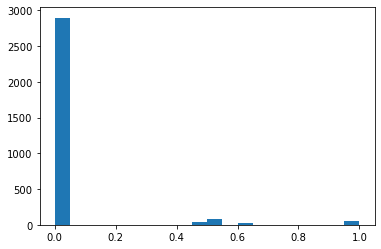

In [19]:
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.show()

In [20]:
gen_model.learned_lf_stats()

,Accuracy,Coverage,Precision,Recall
0,0.975259,0.8690,0.969705,0.845563
1,0.670006,0.6888,0.619951,0.457440
2,0.647399,0.6747,0.594105,0.436893
3,0.976824,0.8716,0.972465,0.853240
4,0.544127,0.6640,0.484508,0.360126
5,0.541325,0.6715,0.484275,0.375480
6,0.546118,0.6581,0.490346,0.361255
7,0.564987,0.6609,0.506773,0.371641


### evaluate model performance

Now that we have learned the generative model, we will measure its performances using the provided test set

In [20]:
# Load test-set first
reload_external_labels(session, HW_DIR / "gold_labels.test.json")
L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)

AnnotatorLabels created: 0
AnnotatorLabels created: 0


In [21]:
L_dev = labeler.apply_existing(split=1)
tp, fp, tn, fn = gen_model.error_analysis(session, L_dev, L_gold_dev)

  7%|▋         | 23/346 [00:00<00:01, 222.53it/s]

Clearing existing...
Running UDF...


100%|██████████| 346/346 [00:01<00:00, 227.23it/s]


Scores (Un-adjusted)
Pos. class accuracy: 0.917
Neg. class accuracy: 0.97
Precision            0.524
Recall               0.917
F1                   0.667
----------------------------------------
TP: 11 | FP: 10 | TN: 324 | FN: 1



Get detailed statistics of LFs learned by the model

In [22]:
L_dev.lf_stats(session, L_gold_dev, gen_model.learned_lf_stats()['Accuracy'])

,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
LF_between,0,1.000000,1.000000,0.078035,8,15,4,319,0.945087,0.975023
LF_organization_right_movie_denial,1,0.225434,0.225434,0.002890,0,0,0,78,1.000000,0.671650
LF_person_right_movie_denial,2,0.147399,0.147399,0.011561,0,0,0,51,1.000000,0.647399
LF_ending_word,3,1.000000,1.000000,0.078035,10,11,2,323,0.962428,0.976957
LF_between_ending,4,0.028902,0.028902,0.008671,7,0,0,3,1.000000,0.546235
LF_usc,5,0.017341,0.017341,0.017341,1,0,0,5,1.000000,0.540879
LF_person_school_distance,6,0.023121,0.023121,0.008671,6,2,0,0,0.750000,0.545510
LF_HarryPotter,7,0.028902,0.028902,0.008671,8,2,0,0,0.800000,0.565138


You might want to look at some examples in one of the error buckets to improve your LFs. For example, below is one of the false negatives that we did not correctly label as true mentions

In [ ]:
# from snorkel.viewer import SentenceNgramViewer

SentenceNgramViewer(fp, session)

## Task 4: Training an End Extraction Model

In this final task, we'll use the noisy training labels we generated to train our end extraction model. In particular, we will be training a Bi-LSTM.

In [25]:
train_cands = session.query(Education).filter(Education.split == 0).order_by(Education.id).all()
dev_cands   = session.query(Education).filter(Education.split == 1).order_by(Education.id).all()
test_cands  = session.query(Education).filter(Education.split == 2).order_by(Education.id).all()

In [26]:
from snorkel.annotations import load_gold_labels

L_gold_dev  = load_gold_labels(session, annotator_name='gold', split=1)
L_gold_test = load_gold_labels(session, annotator_name='gold', split=2)

Try tuning the hyper-parameters below to get your best F1 score

In [30]:
# ** STUDENT CODE

# TODO: tune your hyper-parameters for best results

from snorkel.learning.pytorch import LSTM

train_kwargs = {
    'lr':            0.001, # learning rate of the model
    'embedding_dim': 50,   # size of the feature vector
    'hidden_dim':    50,   # number of nodes in each layer in the model
    'n_epochs':      20,   # number of training epochs
    'dropout':       0.2,  # dropout rate (during learning)
    'batch_size':    70,   # training batch size
    'seed':          1701
}

lstm = LSTM(n_threads=None)
lstm.train(train_cands, train_marginals, X_dev=dev_cands, Y_dev=L_gold_dev, **train_kwargs)

[LSTM] Training model
[LSTM] n_train=3094  #epochs=20  batch size=70
[LSTM] Epoch 1 (7.03s)	Average loss=0.341581	Dev F1=0.00
[LSTM] Epoch 2 (14.57s)	Average loss=0.148260	Dev F1=0.00
[LSTM] Epoch 3 (22.72s)	Average loss=0.121620	Dev F1=0.00
[LSTM] Epoch 4 (30.46s)	Average loss=0.098135	Dev F1=0.00
[LSTM] Epoch 5 (38.01s)	Average loss=0.082487	Dev F1=0.00
[LSTM] Epoch 6 (45.68s)	Average loss=0.070111	Dev F1=0.00
[LSTM] Epoch 7 (53.48s)	Average loss=0.062683	Dev F1=8.70
[LSTM] Epoch 8 (61.86s)	Average loss=0.066948	Dev F1=9.09
[LSTM] Epoch 9 (70.48s)	Average loss=0.056856	Dev F1=22.22
[LSTM] Epoch 10 (79.18s)	Average loss=0.052254	Dev F1=22.22
[LSTM] Epoch 11 (88.15s)	Average loss=0.051226	Dev F1=22.22
[LSTM] Epoch 12 (96.78s)	Average loss=0.049263	Dev F1=34.48
[LSTM] Epoch 13 (105.41s)	Average loss=0.050772	Dev F1=30.30
[LSTM] Epoch 14 (114.40s)	Average loss=0.050248	Dev F1=43.75
[LSTM] Epoch 15 (123.38s)	Average loss=0.046915	Dev F1=45.16
[LSTM] Epoch 16 (132.26s)	Average loss=0.04664

**Report performance of your final extractor**

In [31]:
p, r, f1 = lstm.score(test_cands, L_gold_test)
print("Prec: {0:.3f}, Recall: {1:.3f}, F1 Score: {2:.3f}".format(p, r, f1))

Prec: 0.406, Recall: 0.542, F1 Score: 0.464


In [32]:
tp, fp, tn, fn = lstm.error_analysis(session, test_cands, L_gold_test)

Scores (Un-adjusted)
Pos. class accuracy: 0.542
Neg. class accuracy: 0.978
Precision            0.406
Recall               0.542
F1                   0.464
----------------------------------------
TP: 13 | FP: 19 | TN: 847 | FN: 11



Use your new model to extract relation in testing documents, and save it to JSON files.

In [33]:
# ** STUDENT CODE

# TODO: change to your name
save_predicted_relations(HW_DIR / "Firstname_Lastname_hw05_extracted_relation.test.json", test_cands, lstm.predictions(test_cands))